# start

In [1]:
#########################
PRFX = 'MelInf0726B1tta8'#
PRFX_B4 = 'Mel0726B1'
N_TTA = 8
#########################

p_b4 = f'../output/{PRFX_B4}'

BS = 40

class Param: pass
import pickle
res_b4 = pickle.load(open(f'{p_b4}/results_{PRFX_B4}.p', 'rb'))
param = res_b4['param']
param.__dict__

{'PRFX': 'Mel0726B1',
 'F_PSD': None,
 'PRFX_B4': None,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'LASTM': 3,
 'BS': 40,
 'SEED': 101,
 'EPOCHS': 10,
 'K': 4,
 'FLDS2USE': range(0, 4),
 'FP16': True,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
DEVICE = 'cuda'; 
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

In [3]:
!nvidia-smi

Mon Jul 27 18:17:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   60C    P0   217W / 300W |   9520MiB / 16160MiB |     79%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [4]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# import pretrainedmodels
from efficientnet_pytorch import EfficientNet
# import geffnet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

# prep

In [5]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

if param.N_SAMPL is not None: dftrn = dftrn.sample(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
0,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_7279968,0.0
1,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_3075186,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [6]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [7]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 43524 14508
1 43524 14508
2 43524 14508
3 43524 14508


0.0    0.910739
1.0    0.089261
Name: target, dtype: float64

0.0    0.911704
1.0    0.088296
Name: target, dtype: float64

0.0    0.911221
1.0    0.088779
Name: target, dtype: float64

0.0    0.914599
1.0    0.085401
Name: target, dtype: float64

20    24544
19    18980
Name: source, dtype: int64

20    24521
19    19003
Name: source, dtype: int64

20    24435
19    19089
Name: source, dtype: int64

20    24603
19    18921
Name: source, dtype: int64

In [8]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [9]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

14508 8157
14508 8180
14508 8266
14508 8098


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if self.mode == 'no_tta':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Normalize(), 
                AT.ToTensor(),
            ]) 
        else:
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.RandomBrightnessContrast(),
#                 A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
#                 A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=3),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode !='tst':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
if param.DEBUG: 
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)

In [12]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

# train

## TTA

In [14]:
def evaluate(model, dl, ntta=N_TTA):
    model.eval()
    prd=[]
    y=[]   
    for i in range(ntta):
        prdi = []
        for step, dat in enumerate(dl):
            xb, yb = (o.to(device) for o in dat)
            if i==0: y.append(yb.cpu().detach().numpy())
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi) 
        if i==0: y=np.concatenate(y)  
        prd.append(prdi)
    prd = np.mean(prd, 0)
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [15]:
def infer(model, dl):
    model.eval()
    prd=[]
    for i in range(N_TTA):
        prdi = []
        for step, dat in enumerate(dl):
            xb=dat[0].to(device)
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi)    
        prd.append(prdi)
    prd = np.mean(prd, 0)
    return prd

## set up data

In [16]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    cols2use=['im_pth', 'target']
    if param.F_PSD is not None:
        dftr= pd.concat([dftrn[cols2use].iloc[tr], dfpsd[cols2use]])
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dltr = DataLoader(dstr, batch_size=BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    return dltr,dlvl

## run val

In [17]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param
results['fld2stats']={}

In [18]:
for fld in param.FLDS2USE:    
    tr,vl=fld2trvl[fld]
    dltr,dlvl=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl:', len(dltr), len(dlvl))

    mdl = mkmdl().to(device)

    stats = {
    'lss': {'tr':[],'vl':[],},
    'scr': {'tr':[],'vl':[],},
    }
    ep2oof = []
    best_scr = float('-inf')
    best_epc = -1    
    
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        fnm_mdl_b4 = f'{p_b4}/model_{PRFX_B4}_fld_{fld}_epc_{epc}.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_vl {lss_vl_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc

        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))  
        
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl: 1089 182
Loaded pretrained weights for efficientnet-b0
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_7.p
2020-07-27 18:20:38 fld 0 ep 7: lss_vl 0.285; scr_vl 0.917; 
better scr -inf -> 0.917
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_8.p
2020-07-27 18:24:12 fld 0 ep 8: lss_vl 0.273; scr_vl 0.920; 
better scr 0.917 -> 0.920
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_9.p
2020-07-27 18:27:42 fld 0 ep 9: lss_vl 0.278; scr_vl 0.915; 
fld:1; dltr,dlvl: 1089 182
Loaded pretrained weights for efficientnet-b0
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_7.p
2020-07-27 18:31:17 fld 1 ep 7: lss_vl 0.290; scr_vl 0.927; 
better scr -inf -> 0.927
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_8.p
2020-07-27 18:34:51 fld 1 ep 8: lss_vl 0.279; scr_vl 0.932; 
better scr 0.927 -> 0.932
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_9.p
202

In [19]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))  

# training trajec

In [20]:
for fld,stats in results['fld2stats'].items():
    print(f"fld {fld} best_epc: {stats['best_epc']}; best_scr: {stats['best_scr']:.4f};")

fld 0 best_epc: 8; best_scr: 0.9200;
fld 1 best_epc: 8; best_scr: 0.9315;
fld 2 best_epc: 8; best_scr: 0.9219;
fld 3 best_epc: 9; best_scr: 0.9258;


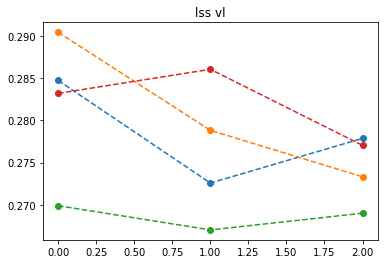

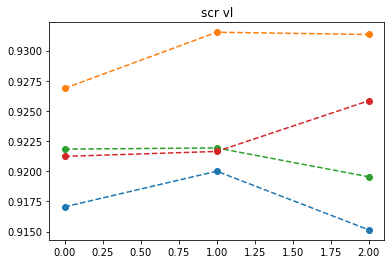

In [21]:
for mtrc in ['lss', 'scr']:
    for k in ['vl',]:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [22]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 1, 4, 6, 10, 15, 17, 19, 21, 29])

## only last epoch 

In [23]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9228771251089061

In [24]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.8926887768115693

## only best_scr epoch

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc =  results['fld2stats'][fld]['best_epc'] - (param.EPOCHS - param.LASTM)
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9244269812165449

In [26]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.8954850356773116

## avg last m epochs

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9258364172382461

In [28]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.8961511854212795

In [29]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [30]:
for m in range(1,param.LASTM+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.4f}', )

1 0.9229
2 0.9256
3 0.9258


In [31]:
for m in range(1, param.LASTM+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    auc20=roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])
    print(m, f'{auc20:.4f}')


1 0.8927
2 0.8971
3 0.8962


# Inference

In [32]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


10982
138


In [33]:
# avg last m epochs
mdl = mkmdl().to(device)
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        mdl.load_state_dict(torch.load(f'{p_b4}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p'))
        prdtst = infer(mdl, dltst)
        dfsub.target = sigmoid(prdtst)
        dfsub.to_csv(f'{p_out}/submission_{PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
        print(dtnow(), f'fld {fld} ep {epc}', f'{dfsub.target.mean():.4f}')


Loaded pretrained weights for efficientnet-b0
2020-07-27 19:02:43 fld 0 ep 7 0.1691
2020-07-27 19:05:24 fld 0 ep 8 0.1556
2020-07-27 19:08:03 fld 0 ep 9 0.1639
2020-07-27 19:10:53 fld 1 ep 7 0.1828
2020-07-27 19:13:32 fld 1 ep 8 0.1773
2020-07-27 19:16:12 fld 1 ep 9 0.1747
2020-07-27 19:18:54 fld 2 ep 7 0.1712
2020-07-27 19:21:35 fld 2 ep 8 0.1649
2020-07-27 19:24:15 fld 2 ep 9 0.1655
2020-07-27 19:26:57 fld 3 ep 7 0.1706
2020-07-27 19:29:37 fld 3 ep 8 0.1776
2020-07-27 19:32:16 fld 3 ep 9 0.1679


fld 0 epc 7 0.1691
fld 0 epc 8 0.1556
fld 0 epc 9 0.1639
fld 1 epc 7 0.1828
fld 1 epc 8 0.1773
fld 1 epc 9 0.1747
fld 2 epc 7 0.1712
fld 2 epc 8 0.1649
fld 2 epc 9 0.1655
fld 3 epc 7 0.1706
fld 3 epc 8 0.1776
fld 3 epc 9 0.1679

0.17009652899533706


,image_name,target
0,ISIC_0052060,0.064300
1,ISIC_0052349,0.075230
2,ISIC_0058510,0.064332


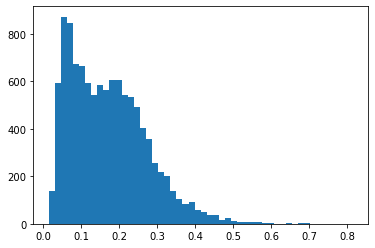

In [34]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        sub_fld_epc = pd.read_csv(f'{p_out}/submission_{PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, f'{sub_fld_epc.target.mean():.4f}')
        lst_sub.append(sub_fld_epc.target.values)
print()
sub = np.mean(lst_sub, 0)
print(sub.mean())
dfsub.target = sub

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [35]:
dfsub.to_csv(f'{p_out}/submission_{PRFX}_avglast{param.LASTM}.csv', index=False)

# fin

In [36]:
param.__dict__

{'PRFX': 'Mel0726B1',
 'F_PSD': None,
 'PRFX_B4': None,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'LASTM': 3,
 'BS': 40,
 'SEED': 101,
 'EPOCHS': 10,
 'K': 4,
 'FLDS2USE': range(0, 4),
 'FP16': True,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [37]:
!nvidia-smi

Mon Jul 27 19:32:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   71C    P0   181W / 300W |  15922MiB / 16160MiB |     47%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  